In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from local_contributor_config import problem_folder
from Plotting.plot_semi_latex import *

In [ ]:
path_to_plots = r'C:/gr_latex/diploma/pictures'

Выделение инсулина на ввод пищи:
1. на белок
2. на жир
3. на глюкозу
4. суммарно

In [ ]:
from F_vec import *
from scipy.integrate import odeint
from myo_supportfs import *
from Plotting.myplt import *
from pprint import pprint
from scipy.integrate import ode,solve_ivp
from euler import euler_solver


index_by_name, name_by_index, start_point = get_start_point_names_mapping(start_point_dict)
# start_point = 0.1+ 10*np.random.rand(len(start_point))
start_point[index_by_name['AA_ef']] = 1.0
start_point[index_by_name['FFA_ef']] = 1.0
start_point[index_by_name['KB_ef']] = 1.0
start_point[index_by_name['Glu_ef']] = 1.0
start_point[index_by_name['INS']] = 0.0


J_flow_carb_vs = J_flow_carb_func.values
J_flow_prot_vs = J_flow_prot_func.values
J_flow_fat_vs  = J_flow_fat_func.values 


INS_on_grid = np.zeros(shape=(len(time_grid), ),dtype=np.float32)
INS_AUC_w_on_grid = np.zeros(shape=(len(time_grid), ),dtype=np.float32)
INS_on_grid[0] = start_point[index_by_name['INS']]
T_a_on_grid = np.zeros(shape=(len(time_grid), ),dtype=np.float32)
INS_AUC_w_on_grid[0] = 0.0
T_a_on_grid[0]= 0.0
last_seen_time = np.zeros(shape=(1,),dtype=np.float32)
last_seen_time[0] = t_0
last_time_pos = np.zeros(shape=(1,),dtype=np.intc)
last_time_pos[0] = 0

def F_wrapped(t, y):
    return F_vec(t,y,INS_on_grid,INS_AUC_w_on_grid,T_a_on_grid,last_seen_time,last_time_pos,
                 J_flow_carb_vs,
                    J_flow_prot_vs,
                    J_flow_fat_vs)

solver = ode(f=F_wrapped,jac=None)
solver.set_initial_value(y=start_point,t=t_0)
# solver_type = 'lsoda'
# solver_type = 'dopri5'
solver_type = 'vode'
solver.set_integrator(solver_type) 
solutions = np.zeros(shape=(len(time_grid),len(start_point)),dtype=np.float32)
solutions[0,:] = solver.y
i_=  1
while solver.successful() and solver.t < t_end:
    solutions[i_,:] = solver.integrate(solver.t+tau_grid)
    i_ += 1 
print('last solver time step {} target last step {}'.format(i_, len(time_grid)-1))
time_sol = time_grid

print(solutions.shape)
print(time_sol.shape)    

In [ ]:
Fat_flow =  np.array([J_flow_fat_func(t) for t in  time_sol])
Prot_flow = np.array([J_flow_prot_func(t) for t in time_sol])
Carb_flow = np.array([J_flow_carb_func(t) for t in time_sol])

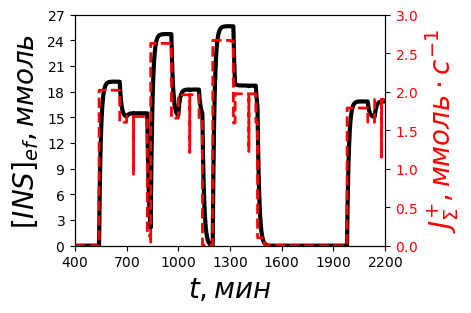

In [46]:
INS_vec = solutions[:,index_by_name['INS']]
t_vec = time_sol
fig,ax = plt.subplots()
fig.set_size_inches(4,3)

ax.plot(t_vec,INS_vec,label = r'$[INS]_{ef}$',c='k',linewidth= 3)

x_ticks = np.arange(np.min(t_vec),np.max(t_vec), 300)
x_labels = [latex_float(tick,0) for tick in x_ticks]
y_ticks = np.arange(np.min(INS_vec),np.max(INS_vec)+3, 3)
y_labels = [latex_float(tick,0) for tick in y_ticks]
ax.set_xlim(x_ticks[0],x_ticks[-1])
ax.set_ylim(y_ticks[0],y_ticks[-1])
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_xticklabels(x_labels)
ax.set_yticklabels(y_labels)
ax.set_xlabel(r'$t,мин$',fontsize = 20)
ax.set_ylabel(r'$[INS]_{ef}, ммоль$',fontsize = 20)
ax2 = ax.twinx()
y2 =Fat_flow+Carb_flow+Prot_flow
y2[np.argwhere(y2==0.0)]=0.0

ax2.plot(time_sol,y2,c='r',linestyle='dashed',linewidth= 2)

# J_{[TG]_{pl}}^{+}+J_{[Glu]_{ef}}^{+}+J_{[AA]_{ef}}^{+},ммоль \cdot c^{-1}
ax2.set_ylabel(r'$J_{\Sigma}^{+},ммоль \cdot c^{-1}$',color='r',fontsize = 20)
y2_ticks = np.arange(np.min(y2),np.max(y2)+0.5, 0.5)
y2_labels = [latex_float(tick,1) for tick in y2_ticks]
ax2.set_yticks(y2_ticks)
ax2.set_yticklabels(y2_labels,color='r')
ax.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.set_ylim(y2_ticks[0],y2_ticks[-1])
# ax2.plot(time_sol,Carb_flow,label=r'$J_{[Glu]_{ef}}^{+}$')
# ax2.plot(time_sol,Prot_flow,label=r'$J_{[AA]_{ef}}^{+}$')
# leg1 = ax.legend(prop = { "size": 14 }, loc ="upper left",bbox_to_anchor=(1.04, 1.03))
# leg1 = ax2.legend(prop = { "size": 14 }, loc ="upper left",bbox_to_anchor=(1.04, 0.8))
fig.savefig(os.path.join(path_to_plots,'INS_total.png'),bbox_inches = 'tight',dpi=1000)

Выделение инсулина в ответ на концентрацию глюкозы в крови.  (Ввод пищи только в вену, без кишечника)

Показать график БМР. поток выходящей энергии- постоянный. При этом компоненты БМР могут меняться (во время еды, ночью и тп), а сумма выходящей энергии в единицу времени - всё рвно постоянная.